## Test how hard one can infer with the VarEM Alogrithm



In [1]:
from models.ICA_EM import *
from models.dgp import *
from models.metrics import *
import importlib, sys
importlib.reload(sys.modules['models.ICA_EM'])
importlib.reload(sys.modules['models.dgp'])
importlib.reload(sys.modules['models.metrics'])
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## simulation to see the effect of enforcing also all zeros



In [2]:

def norm_funtion(A, col):
    # [0,0], [1,1] must be one
    if A[0, col] != 0:
        A_0 = A[:, col] / A[0, col]
    else:
        A_0 = A[:, col]
    return A_0



In [3]:
class CausalVarEM(VarEM):
    def __init__(self, update_sigma=False, true_A=None, tol=1e-4, mode = "each", **kwargs):
        if mode not in ["init", "each"]:
            raise ValueError("mode must be either 'init' or 'each'")
        self.mode = mode
        super().__init__(update_sigma=update_sigma, true_A=true_A, tol=tol, **kwargs)
    
    def update_A(self): # we can force causal structure 
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))

        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)


        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        if self.mode == "each":
            self._enforce_causal_structure()
        return diff
    
    def _initilize_A(self):
        super()._initilize_A()
        self._enforce_causal_structure()
        
    def _enforce_causal_structure(self):
        self.A[0,1] = 0
        # set ones
        self.A[0,0] = 1
        self.A[1,1] = 1
        # set controls to 1
        for j in range(2, self.J-1):
            self.A[j,j+1] = 1


class CausalVarEM_adj(VarEM):
    def __init__(self, update_sigma=False, true_A=None, tol=1e-4, mode = "each", **kwargs):
        if mode not in ["init", "each"]:
            raise ValueError("mode must be either 'init' or 'each'")
        self.mode = mode
        super().__init__(update_sigma=update_sigma, true_A=true_A, tol=tol, **kwargs)
    
    def update_A(self): # we can force causal structure 
        temp1 = np.zeros((self.I, self.J))
        temp2 = np.zeros((self.J, self.J))

        for i in range(self.n):
            omega_i = self._omega_mat(i)
            M_i = self._M_mat(omega_i)
            x_outer = np.outer(self.X[i,:], self.X[i,:])
            temp1 += x_outer @ M_i.T @ self.A @ omega_i
            temp2 += omega_i @ (np.eye(self.J) - self.A.T @ M_i @ (np.eye(self.I) - x_outer @ M_i.T) @ self.A @ omega_i)
            self._update_xi(i, M_i, omega_i, x_outer)
        A_new = temp1 @ np.linalg.inv(temp2)
        if self.update_sigma:
            self._update_sigma(A_new)


        # calculate the difference between the old and new A
        diff = np.linalg.norm(self.A - A_new, ord='fro')
        self.A = A_new
        if self.mode == "each":
            self._enforce_causal_structure()
        return diff
    
    def _initilize_A(self):
        super()._initilize_A()
        self._enforce_causal_structure()
        
    def _enforce_causal_structure(self):
        self.A[0,1] = 0
        # set ones
        self.A[0,0] = 1
        self.A[1,1] = 1
        # set controls to 1
        for j in range(2, self.J-1):
            self.A[j,j+1] = 1
        for j in range(2, self.I): # controls should not be children of treatment
            self.A[j,0] = 0
            self.A[j,1] = 0
            self.A[j,2] = 0
            





In [4]:
n = 10000
J = 6
I = 5
f_score_org = []
f_score_adj = []
mean_squared_error_org = []
mean_squared_error_adj = []
ll_score_org = []
ll_score_adj = []
treatment_true = []
treatment_org = []
treatment_adj = []
data = dgp(prior={"loc" : 0, "scale" : 1/np.sqrt(2)}, noise_dict=  {"loc" : 0, "scale" : 0})
for i in tqdm.tqdm(range(100)):
    data.generate_data(n=n, J=J, I=I, random_state=i)
    treatment_true.append(data.treatment_effect)
    CausalVarEM_est = CausalVarEM(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "each")  
    
    CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    treatment_org.append(norm_funtion(CausalVarEM_est.A, 0)[1])
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
    f_score_org.append(score)
    singals_estimation_VAR = CausalVarEM_est.Signals[:,best_perm]
    mean_squared_error_org.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_org.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))

    CausalVarEM_est = CausalVarEM_adj(update_sigma=False,   true_A= data.mixing_matrix_observed, tol=1e-4, max_iter=200, random_seed=i, mode = "each")
    CausalVarEM_est.fit(data.data_observed, J = J,
                      noise_params= {"mean" : 0, "std" : 1}, progress_bar= False)
    treatment_adj.append(norm_funtion(CausalVarEM_est.A, 0)[1])
    best_perm, score = f_score(data.mixing_matrix_observed, CausalVarEM_est.A)
    f_score_adj.append(score)
    singals_estimation_VAR = CausalVarEM_est.Signals[:,best_perm]
    mean_squared_error_adj.append(mean_squared_error(data.signals, singals_estimation_VAR))
    ll_score_adj.append(likelihood_score(data.signals, singals_estimation_VAR, normalize=True))

df = pd.DataFrame({"f_score_org" : f_score_org, 
                   "f_score_adj" : f_score_adj, 
                   "mean_squared_error_org" : mean_squared_error_org, 
                   "mean_squared_error_adj" : mean_squared_error_adj,
                     "ll_score_org" : ll_score_org, 
                     "ll_score_adj" : ll_score_adj,
                     "treatment_true" :treatment_true,
                     "treatment_org" : treatment_org,
                     "treatment_adj" : treatment_adj})


100%|██████████| 100/100 [2:25:45<00:00, 87.46s/it] 


In [5]:
#df.to_csv("results/CausalVarEM_zero_enforce.csv")


## Results

In [12]:
df = pd.read_csv("results/CausalVarEM_zero_enforce.csv", index_col=0)
print(df.mean())
print(df.std())


f_score_org                   0.164914
f_score_adj                   0.080415
mean_squared_error_org        1.086105
mean_squared_error_adj        0.879326
ll_score_org             -26207.739949
ll_score_adj             -26234.098359
treatment_true               -0.098014
treatment_org                -0.165718
treatment_adj                -0.083395
dtype: float64
f_score_org                  0.111377
f_score_adj                  0.126394
mean_squared_error_org       0.163426
mean_squared_error_adj       0.135079
ll_score_org              1156.049003
ll_score_adj              1425.914578
treatment_true               1.720049
treatment_org                1.822541
treatment_adj                1.688054
dtype: float64


Text(0.5, 0.98, 'Ones vs ones and zeros, true A init')

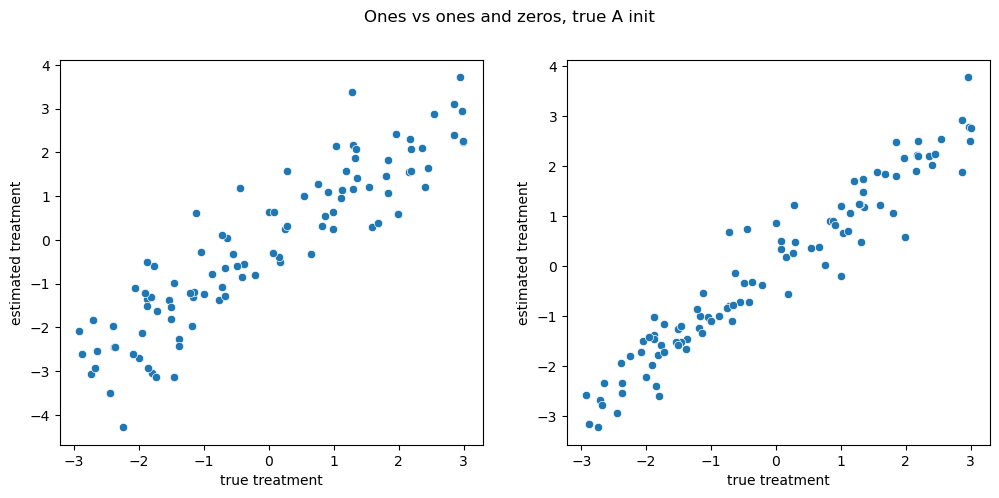

In [16]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
sns.scatterplot(x = "treatment_true", y = "treatment_org", data = df,ax = ax[0])

ax[0].set_ylabel("estimated treatment")
ax[0].set_xlabel("true treatment")




sns.scatterplot(x = "treatment_true", y = "treatment_adj", data = df,ax = ax[1])


ax[1].set_ylabel("estimated treatment")

ax[1].set_xlabel("true treatment")
fig.suptitle("Ones vs ones and zeros, true A init")


In [15]:
from sklearn.metrics import mean_squared_error  as mse

mse(df.treatment_true, df.treatment_org), mse(df.treatment_true, df.treatment_adj)


(np.float64(0.5721650615462677), np.float64(0.20903318312863178))